# Making model

In [ ]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from datetime import datetime
from datetime import date
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.0 MB/s eta 0:00:0000:0100:01


In [3]:
print('pandas=='+ pd.__version__)
print('numpy=='+ np.__version__)

pandas==1.3.5
numpy==1.21.6


In [4]:
# Make loader of big data

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    i = 1
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
        print(f'Loaded ~{i*CHUNKSIZE/1000000} mln rows', end='\r')
        i+=1
    conn.close()
    return pd.concat(chunks, ignore_index=True)
    
  
    
def load_features(quary: str) -> pd.DataFrame:
    return batch_load_sql(quary)

In [5]:
# Load prepared user and post DataFrames

df_user = load_features("""SELECT * FROM scetch_features_dates_lesson_22""")
df_posts = load_features("""SELECT post_id, topic, tfidf, watched_month, top_month  FROM scetch_posts_lesson_22""")
del df_user['index']
del df_user['os']
del df_user['source']
df_user['city'] = df_user['city'] * 10000

In [6]:
df_user.head(3)

,user_id,gender,age,country,city,exp_group,min,max
0,200,1,34,7,5371.900826,3,2021-10-02 14:02:19,2021-12-29 15:24:59
1,201,0,37,7,5348.349921,0,2021-10-04 09:44:05,2021-12-29 08:30:54
2,202,1,17,7,5615.633749,4,2021-10-01 16:03:03,2021-12-29 21:44:30


In [7]:
df_posts.head(3)

,post_id,topic,tfidf,watched_month,top_month
0,1,0,58527,2717,381
1,2,0,12911,2424,246
2,3,0,13782,2746,426


* int8 - Целые числа в диапазоне от -128 по 127 (числа размером 1 байт).
* int16 - Целые числа в диапазоне от -32768 по 32767, (числа размером 2 байта).
* int32 - Целые числа в диапазоне от -2147483648 по 2147483647, (числа размером 4 байта).

In [8]:
# Minimize user dataset
df_user['user_id'] = df_user['user_id'].astype('int32')
df_user['gender'] = df_user['gender'].astype('int8')
df_user['age'] = df_user['age'].astype('int8')
df_user['country'] = df_user['country'].astype('int8')
df_user['city'] = df_user['city'].astype('int16')
df_user['exp_group'] = df_user['exp_group'].astype('int8')
df_user.dtypes

user_id               int32
gender                 int8
age                    int8
country                int8
city                  int16
exp_group              int8
min          datetime64[ns]
max          datetime64[ns]
dtype: object

In [9]:
# Minimize post dataset
df_posts['post_id'] = df_posts['post_id'].astype('int16')
df_posts['topic'] = df_posts['topic'].astype('int8')
df_posts['tfidf'] = df_posts['tfidf'].astype('int32')
df_posts['top_month'] = df_posts['top_month'].astype('int16')
df_posts['watched_month'] = df_posts['watched_month'].astype('int16')
df_posts.dtypes

post_id          int16
topic             int8
tfidf            int32
watched_month    int16
top_month        int16
dtype: object

In [10]:
# Load feed dataset
df_feed = load_features("""SELECT timestamp, user_id, post_id, target FROM public.feed_data WHERE (action='view') AND (timestamp > '2021-12-01')""")

In [11]:
# Minimize feed dataset
df_feed['user_id'] = df_feed['user_id'].astype('int32')
df_feed['post_id'] = df_feed['post_id'].astype('int16')
df_feed['target'] = df_feed['target'].astype('int8')
df_feed['timestamp'] = pd.to_datetime(df_feed['timestamp'])
df_feed.dtypes

timestamp    datetime64[ns]
user_id               int32
post_id               int16
target                 int8
dtype: object

In [12]:
df_feed.head(3)

,timestamp,user_id,post_id,target
0,2021-12-14 15:17:11,100667,6464,0
1,2021-12-14 15:17:55,100667,3859,0
2,2021-12-14 15:19:46,100667,1354,0


In [13]:
# Merging users posts and feed

df_feed = pd.merge(pd.merge(df_feed, df_user, on='user_id'), df_posts, on='post_id')
del df_user
del df_posts

# Adding features

In [14]:
df_feed['hour'] = df_feed['timestamp'].dt.hour.astype('int8')
df_feed['dayofweek'] = df_feed['timestamp'].dt.dayofweek.astype('int8')


# Difference for the previous view
dt = df_feed.sort_values(['user_id', 'timestamp'], ascending=[False, True], kind=['mergesort', 'quicksort'])['timestamp'].diff().astype('timedelta64[s]')
df_feed = df_feed.join(dt, how = 'inner', rsuffix = '_delta')
df_feed['timestamp_delta'] = np.where(df_feed['timestamp_delta'] < 0, 0, df_feed['timestamp_delta'])
df_feed['timestamp_delta'] = df_feed['timestamp_delta'].fillna(0)
df_feed['timestamp_delta'] = df_feed['timestamp_delta'].astype('int32')

# Adding counters
df_feed['counter'] = ((df_feed['timestamp'] - df_feed['min']) / np.timedelta64(1, 's')).astype('int32')
df_feed['delta'] = ((df_feed['max'] - df_feed['timestamp']) / np.timedelta64(1, 's')).astype('int32')
del df_feed['timestamp']
del df_feed['min']
del df_feed['user_id']
del df_feed['post_id']
del df_feed['max']

In [15]:
df_feed.head()

,target,gender,age,country,city,exp_group,topic,tfidf,watched_month,top_month,hour,dayofweek,timestamp_delta,counter,delta
0,0,1,19,10,5261,2,3,9417,2216,251,15,1,86,5598067,874014
1,0,0,36,7,5665,3,3,9417,2216,251,12,3,33,5343697,1023290
2,0,1,23,7,2831,0,3,9417,2216,251,15,2,56,7527011,1440
3,0,1,24,7,3406,3,3,9417,2216,251,11,2,138,5161124,1851698
4,0,0,44,7,3515,4,3,9417,2216,251,13,1,96,7542646,121940


In [ ]:
# Make simple split for time series. W/o stratification and shuffle
y = df_feed['target']
X = df_feed.drop(columns=['target'])
del df_feed

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20,
                                                    shuffle=False,
                                                   # stratify=y
                                                   )

In [17]:
# Checking stratification of data
y.value_counts(), y.value_counts()[1] / y.value_counts()[0]

(0    19077815
 1     3036970
 Name: target, dtype: int64,
 0.1591885653571963)

In [18]:
# Checking stratification of data
y_train.value_counts(), y_train.value_counts()[1] / y_train.value_counts()[0]

(0    15214794
 1     2477034
 Name: target, dtype: int64,
 0.16280430743919372)

In [19]:
# Checking stratification of data
y_test.value_counts(), y_test.value_counts()[1] / y_test.value_counts()[0]

(0    3863021
 1     559936
 Name: target, dtype: int64,
 0.1449476976697771)

In [20]:
import catboost as ctb

CAT = ['hour', 'city', 'dayofweek', 'gender', 'country', 'exp_group', 'topic']
CTB = ctb.CatBoostClassifier(iterations=1000,  
                             cat_features = CAT, 
                             learning_rate=0.12, 
                             l2_leaf_reg=9, 
                             depth=12,
                             used_ram_limit = '15gb',
                             max_ctr_complexity = 1, 
                             early_stopping_rounds = 20,
                             task_type="GPU",
                             auto_class_weights = 'Balanced'
                             #class_weights = {0: (45/334), 1: (334/45)}
                            )

In [21]:
CTB.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features = CAT, plot=False, verbose=10)

0:	learn: 0.6768424	test: 0.6745223	best: 0.6745223 (0)	total: 482ms	remaining: 8m 1s
10:	learn: 0.6268174	test: 0.6170823	best: 0.6170823 (10)	total: 5.42s	remaining: 8m 7s
20:	learn: 0.6204353	test: 0.6104052	best: 0.6104052 (20)	total: 10.2s	remaining: 7m 56s
30:	learn: 0.6188187	test: 0.6086207	best: 0.6086207 (30)	total: 14.9s	remaining: 7m 47s
40:	learn: 0.6177906	test: 0.6076520	best: 0.6076520 (40)	total: 19.8s	remaining: 7m 43s
50:	learn: 0.6170825	test: 0.6071129	best: 0.6071129 (50)	total: 24.8s	remaining: 7m 40s
60:	learn: 0.6164555	test: 0.6066098	best: 0.6066098 (60)	total: 29.6s	remaining: 7m 34s
70:	learn: 0.6158107	test: 0.6061307	best: 0.6061307 (70)	total: 34.3s	remaining: 7m 29s
80:	learn: 0.6151641	test: 0.6056259	best: 0.6056259 (80)	total: 39.1s	remaining: 7m 24s
90:	learn: 0.6145597	test: 0.6051380	best: 0.6051380 (90)	total: 43.8s	remaining: 7m 17s
100:	learn: 0.6141299	test: 0.6048140	best: 0.6048140 (100)	total: 48.6s	remaining: 7m 12s
110:	learn: 0.6134577	t

In [22]:
CTB.get_feature_importance(prettified=True).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Feature Id,hour,timestamp_delta,delta,counter,city,age,dayofweek,exp_group,watched_month,top_month,gender,tfidf,topic,country
Importances,14.217152,13.646943,12.693311,12.039501,11.32057,9.257857,8.561926,5.436821,5.111326,4.258451,1.22447,0.973098,0.678457,0.580118


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, CTB.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79   3863021
           1       0.24      0.70      0.36    559936

    accuracy                           0.68   4422957
   macro avg       0.59      0.69      0.58   4422957
weighted avg       0.85      0.68      0.74   4422957



In [24]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, CTB.predict_proba(X_test)[:,1])

f_scores = 2*precision*recall/(precision+recall)
f_scores = np.nan_to_num(f_scores)

print("Best F-score: ", np.max(f_scores))
print("Threshold for best F-score: ", thresholds[np.argmax(f_scores)])
print("Recall for best F-score: ",  recall[np.argmax(f_scores)])
print("Precision for best F-score: ",  precision[np.argmax(f_scores)])

Best F-score:  0.37422478443704066
Threshold for best F-score:  0.577795548848982
Recall for best F-score:  0.5355969253628986
Precision for best F-score:  0.28757896674862204


ROC-AUC:  0.767


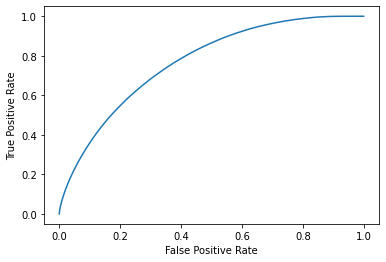

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, CTB.predict_proba(X_test)[:,1])

from sklearn.metrics import RocCurveDisplay, auc

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print("ROC-AUC: ", round(auc(fpr, tpr),3))

RR-AUC:  0.323


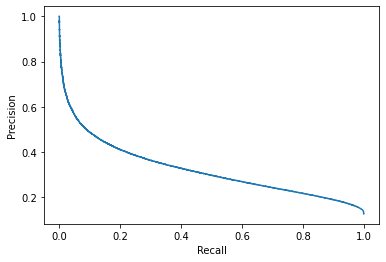

In [26]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay(precision=precision, recall=recall).plot()
print("RR-AUC: ", round(auc(recall, precision),3))

In [27]:
CTB.save_model('Model', format="cbm")

In [28]:
 print("Tree count: ", CTB.tree_count_)

Tree count:  999
